<a href="https://colab.research.google.com/github/mehsheed/cmput267/blob/main/ass4_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install otter-grader
%pip install -q otter-grader

# Download the tests directory from the course website (this will be used by otter-grader)
!wget -q https://vladtkachuk4.github.io/machinelearning1/assignments/Fall2024/ass4/tests.zip -O tests.zip

# Unzip the tests directory, forcing overwriting of existing files
!unzip -qo tests.zip -d .

In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook(colab=True)

# CMPUT 267 - Machine Learning I
# Assignment 4 - Optimization for Regression

## Assignment Instructions and Information
For this assignment, we will be using Google Colab. If you are new to Google Colab, you can find a brief introduction at the following link: [Google Colab Introduction](https://colab.research.google.com/notebooks/intro.ipynb).

**Important:** Before you start working on this notebook, make sure to save a copy to your own Google Drive. To do this, go to `File` -> `Save a copy in Drive`.

If you do not save a copy, you will not be able to save any changes you make.


### Submitting your assignment
Once you have completed the assignment, please submit your work as a `.ipynb` file on eClass in the "Assignment 4" section. To download your Colab notebook in the required format, follow these steps:

1. Save your notebook to ensure all changes are preserved.
2. Navigate to `File` -> `Download` -> `Download .ipynb`.

Make sure to save your notebook before downloading it!

### Questions and Autograding

Each section contains questions for you to solve, marked with the subsection heading "Question X.Y" (ex: the first problem is "Question 2.1").

For each question your solution must go within the following designated code block:

```python
### YOUR CODE HERE ###

######################
```

All questions will be autograded using [Otter-Grader](https://otter-grader.readthedocs.io/en/latest/).
The first two code cells in this notebook install the Otter-Grader package and download the test cases.
You should run these cells, otherwise the autograder will not work.

At the end of each question there is code that runs the autograder. For example, in question Question 2.1 the code `grader.check("q2.1")` runs the autograder.
If you pass all the test cases for a question (ex: Question 2.1), you will see the following output:

**q2_1** passed!

If you do not pass all the test cases for a question, you will see which test cases you did not pass along with their corresponding error messages.

There are both public and private test cases. You only have access to the public test cases. This means that if you pass all the test cases in this notebook, you have passed all the public test cases.

After you submit the assignment, we will also run the private test cases. The public test cases account for 50% of the total mark, while the private test cases make up the remaining 50%. Therefore, if you pass all the test cases in the notebook, you are guaranteed a mark of at least 50%.

After each question description, the number of points (marks) the question is worth is indicated.
This is the total number of points for both the public and private test cases.
For each question, the public test cases are worth 50% of the points.


## Introduction

Welcome to Assignment 4! In this assignment, you will explore optimization techniques in the context of linear regression.
You will be implementing various optimization algorithms as described in Chapter 6 of the [course notes](https://vladtkachuk4.github.io/machinelearning1/notes.pdf).

This assignment will guide you through the following sections:

1. [Understanding the Dataset](#part-1-understanding-the-dataset)
2. [Closed Form Solution](#part-2-closed-form-solution)
3. [Batch Gradient Descent](#part-3-batch-gradient-descent)
6. [Polynomial Regression](#part-4-polynomial-regression)
5. [Mini-Batch Gradient Descent](#part-5-mini-batch-gradient-descent)
4. [Step Sizes](#part-6-step-sizes)

You can quickly navigate to each section by opening the table of contents on the left side of the screen.

In class we learned that Empirical Risk Minimization (ERM) is a Learner that has two steps:
1. Estimation: $\hat L(f)$ is an estimate of the true loss $L(f)$ for each $f \in \mathcal{F}$.
2. Optimization: Find $f \in \mathcal{F}$ that minimizes $\hat L(f)$.

In this assignment, we will focus on implementing the ERM learner using various optimization techniques.

We will **not** discuss how to evaluate the learner.
In particular, recall that our objective in supervised learning was to minimize the expected loss $L(f)$, which captures how well the learner generalizes to unseen data.
In this assignment we will assume that $\hat L(f)$ is a good estimate of $L(f)$, and we will focus on the optimization step.
How well the `predictor` $\hat f$ output by our learner does at predicting unseen data will be the focus of the next coding assignment.

Let's get started!


# Part 1: Understanding the Dataset

In this assignment, we will use the **California Housing Prices dataset**, which is a classic dataset often used for linear regression tasks. It contains information about various features of houses in California, such as median income (in tens of thousands of dollars), average number of rooms, and the location of the houses, among others, with the targets (labels) being the median house price.

The dataset is from the **1990 California census**.

Let's begin by loading the dataset and taking a closer look at what it contains.

### Load the Dataset

First, lets import all the necessary libraries for this assignment.

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interactive_output
import ipywidgets as widgets
from IPython.display import display, clear_output

# Set a fixed random seed for reproducibility
random_seed = 42

We will use the `fetch_california_housing` dataset from the `sklearn.datasets` module.
Let's load the dataset and examine the features for the first few datapoints.
You should see that the dataset contains 8 features and a target value (price).

In [ ]:
# Load the California housing dataset
data = fetch_california_housing()
print(data.DESCR)

# Convert to a DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Price'] = data.target

# Display the first few rows of the dataset
df.head()

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Data Preprocessing

In the California Housing Prices dataset, houses with prices over $500,000 were capped at $500,000. This capping can cause some undesirable behaviors when learning a good predictor because it introduces a ceiling effect, where the true variability of house prices above $500,000 is not captured. As a result, the model might not learn the true relationship between the features and the target variable for high-priced houses.

To address this issue, we will remove any datapoints from our dataset that have a price of exactly $500,000. This will help ensure that our model learns a more accurate relationship between the features and the target variable.

Additionally, to make it easier to visualize and work with the data, we will only use the first 500 datapoints in this assignment. This will allow us to create more manageable plots and computations.

Here is the code to preprocess the dataset:


In [ ]:
# Filter out houses with prices of $500k and above
df = df[df['Price'] < 5]

# Select the first 500 data points
df_small = df.iloc[:500]

Now that we have loaded and filtered the dataset, we need to prepare it for use in our linear regression models.
We will store all the features in a matrix $\mathbf{X}$ where each row represents a data point and each column represents a feature.
Additionally, we will append a column of 1s as the first column of $\mathbf{X}$, which will be used to multiply the bias term in the weights.
We will also store the target values (house prices) in a vector $\mathbf{Y}$.

For implementation reasons, it is usually preferred to store all the features in a matrix $\mathbf{X}$ with each row being a data point and each column being a feature. This allows for efficient matrix operations and simplifies the implementation of algorithms.

We will also *normalize* the features.
Normalization is the process of scaling the features so that they have a mean of 0 and a standard deviation of 1. This is important because it ensures that all features contribute equally to the model and prevents features with larger scales from dominating the learning process. In machine learning, normalization is commonly done to improve the convergence of gradient-based optimization algorithms and to ensure that the model's performance is not biased towards features with larger numerical ranges.

For example, consider two features: Population and HouseAge. The Population feature might have values ranging from hundreds to thousands, while HouseAge might have values ranging from 0 to 100. Without normalization, the Population feature could dominate the learning process because of its larger numerical range. Normalization ensures that both features contribute equally to the model, regardless of their original scales.

Below, we preprocess the data in this way.

In [ ]:
# Extract features and target
X = df_small.drop(columns=['Price']).values
Y = df_small['Price'].values

# Append a column of 1s to X for the bias term
X = np.hstack([np.ones((X.shape[0], 1)), X])

# Normalize the features in X, excluding the first column
X_mean = X[:, 1:].mean(axis=0)
X_std = X[:, 1:].std(axis=0)
X = np.hstack([X[:, :1], (X[:, 1:] - X_mean) / X_std])


array([[ 1.        ,  2.83234658, -0.39072001, ..., -0.15595725,
         1.49282074,  0.06202666],
       [ 1.        ,  2.81908868, -2.58824539, ..., -0.66581635,
         1.04760131,  0.28676095],
       [ 1.        ,  2.23752344,  0.81791895, ...,  0.1262518 ,
         0.8249916 , -0.16270762],
       ...,
       [ 1.        , -0.53287731,  0.81791895, ..., -0.82117829,
         0.8249916 , -0.83691048],
       [ 1.        , -1.03734615,  0.2685376 , ..., -0.0563477 ,
         0.8249916 , -0.83691048],
       [ 1.        , -0.18878454,  0.81791895, ..., -0.64414366,
         0.8249916 , -1.06164477]])

### Visualizing the Data

To start understanding our dataset better, let's visualize the relationship between the **median income** feature (`MedInc`) and the **house price** (`Price`). This can help us get an initial sense of how one of the key features relates to the target variable.

You should notice a positive correlation between the median income and the house price, which is expected since houses in areas with higher median incomes tend to be more expensive.
It also looks like a line might be a good fit for this data.

To view this and all future plots you must click the "Show plot" checkbox.

Checkbox(value=True, description='Show Plot')

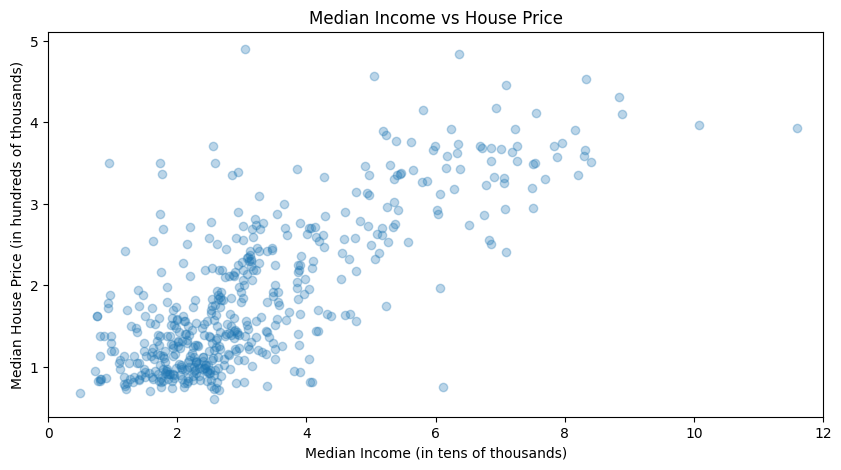

In [ ]:
# @title Plot

# Create a checkbox widget
show_plot_checkbox_medinc = widgets.Checkbox(
    value=False,
    description='Show Plot',
    disabled=False
)

# Function to plot the data
def plot_data_medinc(change):
    clear_output(wait=True)  # Clear the output before plotting or closing the plot
    display(show_plot_checkbox_medinc)  # Re-display the checkbox after clearing

    if show_plot_checkbox_medinc.value:
        plt.figure(figsize=(10, 5))
        plt.scatter(df_small['MedInc'], df_small['Price'], alpha=0.3)
        plt.xlabel('Median Income (in tens of thousands)')
        plt.ylabel('Median House Price (in hundreds of thousands)')
        plt.title('Median Income vs House Price')
        plt.xlim(0, 12)
        plt.show()

# Attach the function to the checkbox
show_plot_checkbox_medinc.observe(plot_data_medinc, names='value')

# Display the checkbox
display(show_plot_checkbox_medinc)

Now lets visualize the relationship between the number of rooms (`AveRooms`) and the house price (`Price`).

For this plot you should notice a weaker relationship between the number of rooms and the house price compared to the median income.
The relationship is not as clear, and in the [Polynomial Regression](#part-4-polynomial-regression) section, we will see that a quadratic function might be a better fit for this data.

Checkbox(value=True, description='Show Plot')

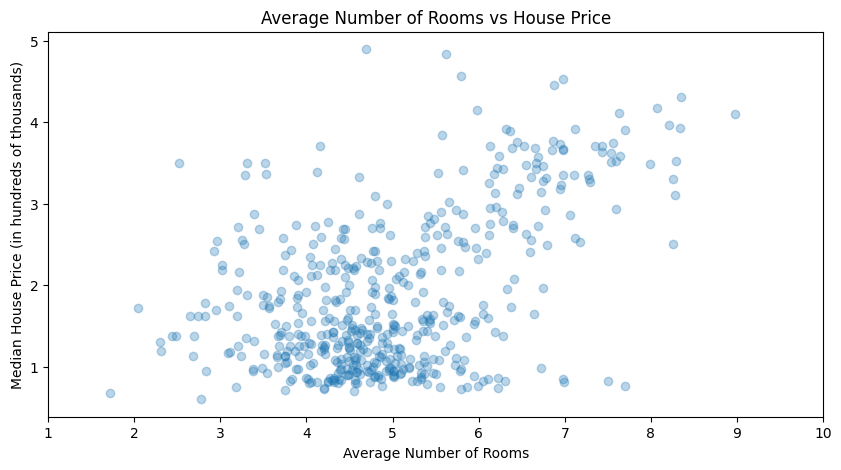

In [ ]:
# @title Plot

# Create a checkbox widget
show_plot_checkbox_rooms = widgets.Checkbox(
    value=False,
    description='Show Plot',
    disabled=False
)

# Function to plot the data
def plot_data_rooms(change):
    clear_output(wait=True)  # Clear the output before plotting or closing the plot
    display(show_plot_checkbox_rooms)  # Re-display the checkbox after clearing

    if show_plot_checkbox_rooms.value:
        plt.figure(figsize=(10, 5))
        plt.scatter(df_small['AveRooms'], df_small['Price'], alpha=0.3)
        plt.xlabel('Average Number of Rooms')
        plt.ylabel('Median House Price (in hundreds of thousands)')
        plt.title('Average Number of Rooms vs House Price')
        plt.xlim(1, 10)
        plt.show()

# Attach the function to the checkbox
show_plot_checkbox_rooms.observe(plot_data_rooms, names='value')

# Display the checkbox
display(show_plot_checkbox_rooms)

Lets plot one more feature, the longitude (`Longitude`) against the house price (`Price`).

In this plot you should see that there is no clear relationship between the longitude and the house price.

Checkbox(value=True, description='Show Plot')

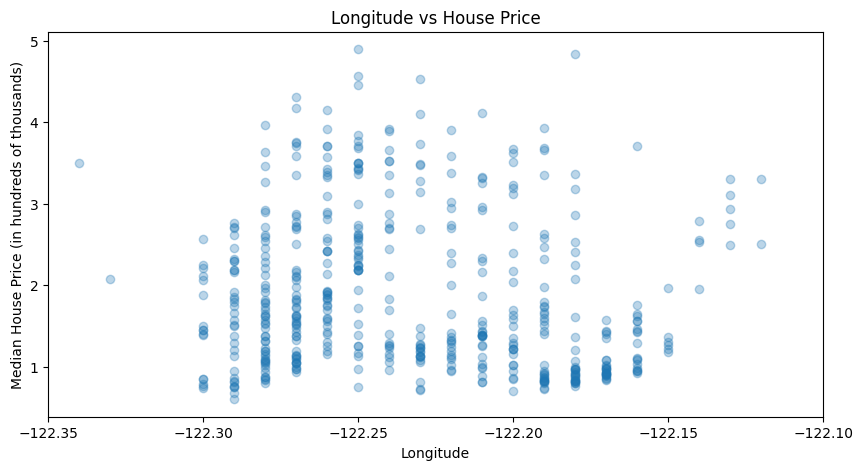

In [ ]:
# @title Plot

# Create a checkbox widget
show_plot_checkbox_longitude = widgets.Checkbox(
    value=False,
    description='Show Plot',
    disabled=False
)

# Function to plot the data
def plot_data_longitude(change):
    clear_output(wait=True)  # Clear the output before plotting or closing the plot
    display(show_plot_checkbox_longitude)  # Re-display the checkbox after clearing

    if show_plot_checkbox_longitude.value:
        plt.figure(figsize=(10, 5))
        plt.scatter(df_small['Longitude'], df_small['Price'], alpha=0.3)
        plt.xlabel('Longitude')
        plt.ylabel('Median House Price (in hundreds of thousands)')
        plt.title('Longitude vs House Price')
        plt.xlim(-122.35, -122.1)
        plt.show()

# Attach the function to the checkbox
show_plot_checkbox_longitude.observe(plot_data_longitude, names='value')

# Display the checkbox
display(show_plot_checkbox_longitude)

What we wanted to highlight with these plots is that not all features will have a strong linear relationship with the target variable, and in some cases, a linear model might not be the best fit for the data.

Now that we have a better understanding of the dataset, we can move on to implementing some learning algorithms, beginning with the closed-form solution.


# Part 2: Closed Form Solution

In this section, you will implement the closed form solution for linear regression.

In class we learned that the closed form linear regression learner is defined as:


$$\mathcal{A}(\mathcal{D}) = \hat f \quad \text{where} \quad \hat f = \mathbf{x}^\top \hat{\mathbf{w}}$$

and

$$\hat{\mathbf{w}} = \mathbf{A}^{-1} \mathbf{b}, \quad \text{where} \quad \mathbf{A} = \sum_{i=1}^n \mathbf{x}_i \mathbf{x}_i^\top, \quad \mathbf{b} = \sum_{i=1}^n \mathbf{x}_i y_i$$

In Question 2.1 your goal is to define the learner $\mathcal{A}$ as a function `closed_form_learner` that takes as input `X` and `Y` (which is our dataset $\mathcal{D}$) and returns the function `predictor`, which represents $\hat f$.

Note that `closed_form_learner` also returns `w_hat` because we will use it for plotting purposes later.

**A note on implementation:**
Some helpful functions and syntax for this question are:
- `*` for scalar multiplication (e.g. `2 * x` is the scalar product of `x` with 2).
- `@` for matrix multiplication (e.g. `A @ B` is the matrix product of `A` and `B`, and `A @ x` is the matrix-vector product of `A` and `x`).
- `.T` for the transpose of a matrix (e.g. `A.T` is the transpose of `A`).
- `.shape` to get the shape of a matrix (e.g. if `A` is a matrix, `A.shape` is a tuple containing the number of rows and columns of `A`).
- `np.outer` for the outer product of two vectors (e.g. `np.outer(x, x)` is the outer product of `x` with itself).
- `np.linalg.pinv` for the inverse of a matrix (e.g. `np.linalg.pinv(A)` is the inverse of `A`).

You can implement the above sums using a for loop; however, it is much more common to use matrix operations to compute these sums.
This is because matrix operations are much faster and more efficient than using for loops.

To see how this can be done, notice that $\mathbf{X}, \mathbf{X}^\top$ and $\mathbf{Y}$ can be visualized as follows:
$$
\mathbf{X} = \begin{bmatrix}
\mathbf{x}_1^\top \\
\mathbf{x}_2^\top \\
\vdots \\
\mathbf{x}_n^\top \\
\end{bmatrix}, \quad
\mathbf{X}^\top = \begin{bmatrix}
\mathbf{x}_1 & \mathbf{x}_2 & \cdots & \mathbf{x}_n
\end{bmatrix}, \quad
\mathbf{Y} = \begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n \\
\end{bmatrix}
$$
Now, if we calculate $\mathbf{X}^\top \mathbf{Y}$ we would get:
$$
\mathbf{X}^\top \mathbf{Y} = \begin{bmatrix}
\mathbf{x}_1 & \mathbf{x}_2 & \cdots & \mathbf{x}_n
\end{bmatrix}
\begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n \\
\end{bmatrix}
= \mathbf{x}_1 y_1 + \mathbf{x}_2 y_2 + \cdots + \mathbf{x}_n y_n
= \sum_{i=1}^n \mathbf{x}_i y_i
$$
Notice how this is exactly equal to $\mathbf{b}$.
On a similar note, if we calculate $\mathbf{X}^\top \mathbf{X}$ we would get (I don't expect you to know why the last equality holds):
$$
\mathbf{X}^\top \mathbf{X} = \begin{bmatrix}
\mathbf{x}_1 & \mathbf{x}_2 & \cdots & \mathbf{x}_n
\end{bmatrix}
\begin{bmatrix}
\mathbf{x}_1^\top \\
\mathbf{x}_2^\top \\
\vdots \\
\mathbf{x}_n^\top \\
\end{bmatrix}
= \sum_{i=1}^n \mathbf{x}_i \mathbf{x}_i^\top
$$

Notice how this is exactly equal to $\mathbf{A}$.








### Question 2.1
Implement `closed_form_learner`.
In particular your code should set `w_hat` as $\hat{\mathbf{w}}$ is defined above.

_Points:_ 8

In [ ]:
def closed_form_learner(X, Y):
    '''
    Solves linear regression using the closed form solution.

    Parameters:
    X (numpy array): Feature matrix of size (n, d+1), where n is the number of samples
                     and d is the number of features. The first column should be all 1s.
    Y (numpy array): Target vector of size (n, 1).

    Returns:
    predictor (function): A function that takes a feature vector and returns a predicted value.
    w_hat (numpy array): The weights calculated using the closed form solution.
    '''
    ### YOUR CODE HERE ###

    # w_hat = np.zeros(X.shape[1]) # this is a placeholder, replace it with the correct value
    w_hat = np.linalg.inv(X.T @ X) @ (X.T @ Y)

    ######################

    def predictor(x):
        return x @ w_hat

    return predictor, w_hat


In [ ]:
grader.check("q2_1")

q2_1 results: All test cases passed!

## Visualizing the Predictor

To get an sense of the quality of the predictor our learner outputs, we will plot the predicted house prices against the true house prices.
To help us visualize things we will only use one feature, the median income, to make the plot.
First lets define a new matrix `X_MedInc` that only contains two columns, the first columns contains all 1s and the second column contains the median income feature.

In [ ]:
X_MedInc = np.hstack([np.ones((X.shape[0], 1)), X[:, 1].reshape(-1, 1)])

Now we can pass `X_MedInc` and `Y` to the `closed_form_learner` to get the predictor and plot it against the true house prices.

You should see the predictor is a line that fits the data well.

Checkbox(value=True, description='Show Plot')

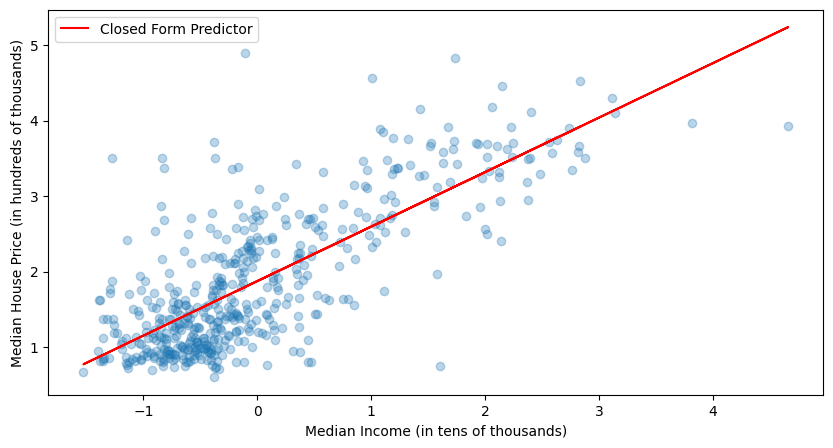

In [ ]:
# @title Plot

# Create a checkbox widget
show_plot_checkbox_cf = widgets.Checkbox(
    value=False,
    description='Show Plot',
    disabled=False
)

# Function to plot the data
def plot_data_cf(change):
    clear_output(wait=True)  # Clear the output before plotting or closing the plot
    display(show_plot_checkbox_cf)  # Re-display the checkbox after clearing

    # Step 1: Call the closed_form_learner to get the predictor function and weights trained on X_MedInc.
    predictor_cf, w_hat_cf = closed_form_learner(X_MedInc, Y)

    # Step 2: Generate predicted values using the predictor function.
    Y_pred_cf = predictor_cf(X_MedInc)

    if show_plot_checkbox_cf.value:
       # Step 4: Plot the original data points and the predicted line, with the desired style.
        plt.figure(figsize=(10, 5))  # Set figure size as in the previous plot.
        plt.scatter(X_MedInc[:, 1:], Y, alpha=0.3)  # Plot actual data with 30% opacity.
        plt.plot(X_MedInc[:, 1:], Y_pred_cf, color='red', label='Closed Form Predictor')  # Plot the predicted line.
        plt.xlabel('Median Income (in tens of thousands)')  # Change the x-axis label.
        plt.ylabel('Median House Price (in hundreds of thousands)')  # Change the y-axis label.
        plt.legend()  # Show the legend.

        # Show the plot.
        plt.show()

# Attach the function to the checkbox
show_plot_checkbox_cf.observe(plot_data_cf, names='value')

# Display the checkbox
display(show_plot_checkbox_cf)


# Part 3: Batch Gradient Descent

Lets now implement the batch gradient descent learner for linear regression.
In class we learned that the batch gradient descent learner is defined as:

$$\mathcal{A}(\mathcal{D}) = \hat f \quad \text{where} \quad \hat f = \mathbf{x}^\top \mathbf{w}^{(T)}, \quad T \in \mathbb{N}$$

and

$$\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta^{(t)} \frac{2}{n} \sum_{i=1}^n (\mathbf{x}_i^\top \mathbf{w}^{(t)} - y_i) \mathbf{x}_i$$

In Question 3.1 your goal is to define the learner $\mathcal{A}$ as a function `batch_gradient_descent_learner` that takes as input:
- `X` and `Y` (which is the dataset $\mathcal{D}$),
- `step_size` which is a constant learning rate, representing $\eta^{(t)} = \eta$,
- `epochs` which is the number of steps to take, representing $T$,
- `random_seed` which is the random seed used for reproducibility when initializing the weights randomly,

and returns the function `predictor`, which represents $\hat f$.
Note that we are assuming a constant learning rate $\eta^{(t)} = \eta$ for this implementation.

**A note on implementation:**
Similar to the closed form solution, you can implement the above sum using a for loop; however, it is much more common to use matrix operations to compute these sums.
To see how this can be done, first notice that
$$
\sum_{i=1}^n (\mathbf{x}_i^\top \mathbf{w}^{(t)} - y_i) \mathbf{x}_i
= \sum_{i=1}^n \mathbf{x}_i (\mathbf{x}_i^\top \mathbf{w}^{(t)} - y_i)
= \sum_{i=1}^n \mathbf{x}_i (\mathbf{x}_i^\top \mathbf{w}^{(t)}) - \sum_{i=1}^n \mathbf{x}_i y_i
$$
We already learned in the previous section that $\mathbf{X}^\top \mathbf{Y} = \sum_{i=1}^n \mathbf{x}_i y_i$.
For the first sum, notice that if we calculate $\mathbf{X}^\top \mathbf{X} \mathbf{w}$ we get:
$$
\mathbf{X}^\top \mathbf{X} \mathbf{w} = \left( \sum_{i=1}^n \mathbf{x}_i \mathbf{x}_i^\top \right) \mathbf{w}
= \sum_{i=1}^n \mathbf{x}_i (\mathbf{x}_i^\top \mathbf{w})
$$


### Question 3.1
Implement `batch_gradient_descent_learner`.
In particular your code should set `w` as $\mathbf{w}^{(t+1)}$ is defined above.

_Points:_ 8

In [ ]:
def batch_gradient_descent_learner(X, Y, step_size=0.01, epochs=10, random_seed=42):
    '''
    Solves linear regression using batch gradient descent.

    Parameters:
    X (numpy array): Feature matrix of size (n, d+1), where n is the number of samples
                     and d is the number of features. The first column should be all 1s.
    Y (numpy array): Target vector of size (n, 1).
    step_size (float): The step size for gradient descent.
    epochs (int): The number of iterations to run gradient descent.
    random_seed (int, optional): The seed for the random number generator.

    Returns:
    predictor (function): A function that takes a feature vector and returns a predicted value.
    w (numpy array): The final weights after applying gradient descent for the specified epochs.
    '''
    n, d = X[:,1:].shape
    np.random.seed(random_seed)
    w = np.random.randn(d+1) # initialize the weights randomly

    ### YOUR CODE HERE ###
    for epoch in range(epochs):
        predictions = X @ w  # Shape: (n,)
        errors = predictions - Y.flatten()  # Shape: (n,)
        gradient = (2 / n) * (X.T @ errors)  # Shape: (d+1,)
        w -= step_size * gradient


    ######################

    def predictor(x):
        return x @ w

    return predictor, w


In [ ]:
grader.check("q3_1")

q3_1 results: All test cases passed!

## Visualizing the Predictor

Similar to the previous section, we will plot the predicted house prices against the true house prices using the median income feature.

You should notice that as the number of epochs increases, the predictor gets closer to the closed form predictor.
This makes sense, because the $\hat{\textbf{w}}$ used by the closed form predictor is
$$\hat{\textbf{w}} = \text{arg} \min_{\textbf{w}} \hat L(\textbf{w})$$
and the $\textbf{w}$ used by the batch gradient descent learner approaches this $\hat{\textbf{w}}$ as the number of epochs increases.

You can use the slider to change the number of `epochs` that the `batch_gradient_descent_learner` runs for.

In [ ]:
# @title Plot
# Create a slider widget for selecting the number of epochs
epochs_slider = widgets.IntSlider(
    value=3,
    min=1,
    max=300,
    step=1,
    description='Epochs:',
    continuous_update=True  # Enable continuous updates for smoother interaction
)

# Create a checkbox widget
show_plot_checkbox_bgd = widgets.Checkbox(
    value=False,
    description='Show Plot',
    disabled=False
)

# Step 1: Call the closed_form_learner to get the predictor function and weights trained on X_MedInc.
predictor_cf, w_hat_cf = closed_form_learner(X_MedInc, Y)

# Step 2: Generate predicted values using the predictor function.
Y_pred_cf = predictor_cf(X_MedInc)

# Function to update the plot based on the selected number of epochs
def update_plot_scatter_bgd(epochs, show_plot):
    if show_plot:
        # Step 1: Call the batch_gradient_descent_learner to get the predictor function and weights trained on X_MedInc.
        bgd_predictor, bgd_weights = batch_gradient_descent_learner(X_MedInc, Y, step_size=0.01, epochs=epochs)

        # Step 2: Generate predicted values using the BGD predictor function.
        Y_pred_bgd = bgd_predictor(X_MedInc)

        # Step 3: Plot the original data points, the closed form predictor line, and the BGD predictor line.
        plt.figure(figsize=(10, 5))  # Set figure size as in the previous plot.
        plt.scatter(X_MedInc[:, 1:], Y, alpha=0.3, label='Actual Data')  # Plot actual data with 30% opacity.
        plt.plot(X_MedInc[:, 1:], Y_pred_cf, color='red', label='Closed Form Predictor')  # Plot the closed form predicted line.
        plt.plot(X_MedInc[:, 1:], Y_pred_bgd, color='blue', label=f'BGD Predictor ({epochs} epochs)')  # Plot the BGD predicted line.
        plt.xlabel('Median Income (in tens of thousands)')  # Change the x-axis label.
        plt.ylabel('Median House Price (in hundreds of thousands)')  # Change the y-axis label.
        plt.ylim(0.4, 5.4)
        plt.legend()  # Show the legend.

        # Show the plot.
        plt.show()
    else:
        # Clear the output to hide the plot when "Show Plot" is unchecked
        clear_output()

# Use interactive_output to update the plot interactively
interactive_plot_scatter_bgd = interactive_output(update_plot_scatter_bgd, {'epochs': epochs_slider, 'show_plot': show_plot_checkbox_bgd})

# Display the slider, checkbox, and interactive plot
display(epochs_slider, show_plot_checkbox_bgd, interactive_plot_scatter_bgd)


IntSlider(value=3, description='Epochs:', max=300, min=1)

Checkbox(value=False, description='Show Plot')

Output()

We can also visualize the estimated loss $\hat L(\mathbf{w})$ over the epochs.
Lets define a function `calculate_loss` that takes in `X`, `Y`, and `w` and returns the estimated loss $\hat L(\mathbf{w})$.

In [ ]:
def calculate_loss(X, Y, w):
    return np.mean((X @ w - Y) ** 2)

Since we are only using one feature, the weight vector $\mathbf{w}$ is a 2-dimensional vector, where the first element is the bias term and the second element is the weight for the median income feature.
Thus we can plot the estimated loss as a function of the 2-dimensional weight vector $\mathbf{w}$.

In the plot you should see that the $\hat{\textbf{w}}$ used by the closed form solution is the minimizer of the estimated loss.
You should also see that the estimated loss for batch gradient descent weight vector $\textbf{w}$ approaches $\hat{\textbf{w}}$ as the number of epochs increases.

You can use the sliders to change the viewing angle of the plot.

In [ ]:
# @title Plot
# Create sliders for elev and azim
elev_slider = widgets.IntSlider(
    value=15,
    min=0,
    max=90,
    step=1,
    description='Elev:',
    continuous_update=True  # Enable continuous updates for smoother interaction
)

azim_slider = widgets.IntSlider(
    value=70,
    min=0,
    max=360,
    step=1,
    description='Azim:',
    continuous_update=True  # Enable continuous updates for smoother interaction
)

# Create a checkbox widget
show_plot_checkbox_mesh = widgets.Checkbox(
    value=False,
    description='Show Plot',
    disabled=False
)

# Run batch gradient descent for different epochs
bgd_predictor_1, bgd_weights_1 = batch_gradient_descent_learner(X_MedInc, Y, step_size=0.01, epochs=1)
bgd_predictor_10, bgd_weights_10 = batch_gradient_descent_learner(X_MedInc, Y, step_size=0.01, epochs=10)
bgd_predictor_50, bgd_weights_50 = batch_gradient_descent_learner(X_MedInc, Y, step_size=0.01, epochs=50)

# Compute the loss values for each set of weights
bgd_loss_1 = calculate_loss(X_MedInc, Y, bgd_weights_1)
bgd_loss_10 = calculate_loss(X_MedInc, Y, bgd_weights_10)
bgd_loss_50 = calculate_loss(X_MedInc, Y, bgd_weights_50)

# Get the closed form solution weights and loss
closed_form_predictor, closed_form_weights = closed_form_learner(X_MedInc, Y)
closed_form_loss = calculate_loss(X_MedInc, Y, closed_form_weights)

# Create a grid of weight values for plotting the loss surface
W0, W1 = np.meshgrid(np.linspace(-0.2, 2.5, 100), np.linspace(-0.5, 1.2, 100))
loss_values = np.zeros_like(W0)

# Compute the loss for each combination of weights
for i in range(W0.shape[0]):
    for j in range(W0.shape[1]):
        w = np.array([W0[i, j], W1[i, j]])
        loss_values[i, j] = calculate_loss(X_MedInc, Y, w)

# Function to update the plot based on the slider values
def update_plot_mesh(elev, azim, show_plot):
    if show_plot:
        # Create a new figure and 3D plot
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(W0, W1, loss_values, cmap='viridis', alpha=0.6)
        ax.scatter(bgd_weights_1[0], bgd_weights_1[1], bgd_loss_1, color='blue', label='BGD Predictor (1 epoch)', s=100)
        ax.scatter(bgd_weights_10[0], bgd_weights_10[1], bgd_loss_10, color='orange', label='BGD Predictor (10 epochs)', s=100)
        ax.scatter(bgd_weights_50[0], bgd_weights_50[1], bgd_loss_50, color='red', label='BGD Predictor (50 epochs)', s=100)
        ax.scatter(closed_form_weights[0], closed_form_weights[1], closed_form_loss, color='green', label='Closed Form Predictor', s=100)
        ax.set_xlabel('Weight w0')
        ax.set_ylabel('Weight w1')
        ax.set_zlabel('Estimated Loss')
        ax.view_init(elev=elev, azim=azim)
        ax.set_title('Estimated Loss as a Function of Weight')
        ax.legend()

        # Display the updated plot
        plt.show()
    else:
        # Clear the output to hide the plot when "Show Plot" is unchecked
        clear_output()

# Use interactive_output to update the plot interactively
interactive_plot_mesh = interactive_output(update_plot_mesh, {'elev': elev_slider, 'azim': azim_slider, 'show_plot': show_plot_checkbox_mesh})

# Display the sliders, checkbox, and interactive plot
display(elev_slider, azim_slider, show_plot_checkbox_mesh, interactive_plot_mesh)


IntSlider(value=15, description='Elev:', max=90)

IntSlider(value=70, description='Azim:', max=360)

Checkbox(value=False, description='Show Plot')

Output()

We can also visualize the estimated loss $\hat L(\mathbf{w})$ over the epochs in a 2D plot.
Here we use a heatmap to represent the estimated loss value.
The darkest blue represents the minimum estimated loss.
You should see that the $\hat{\textbf{w}}$ used by the closed form solution is at the darkest blue region.
You should also see that the estimated loss for the batch gradient descent weight vector $\textbf{w}$ gets closer to $\hat{\textbf{w}}$ after each gradient descent step.
The gradient steps are indicated by the red arrows.

Checkbox(value=True, description='Show Plot')

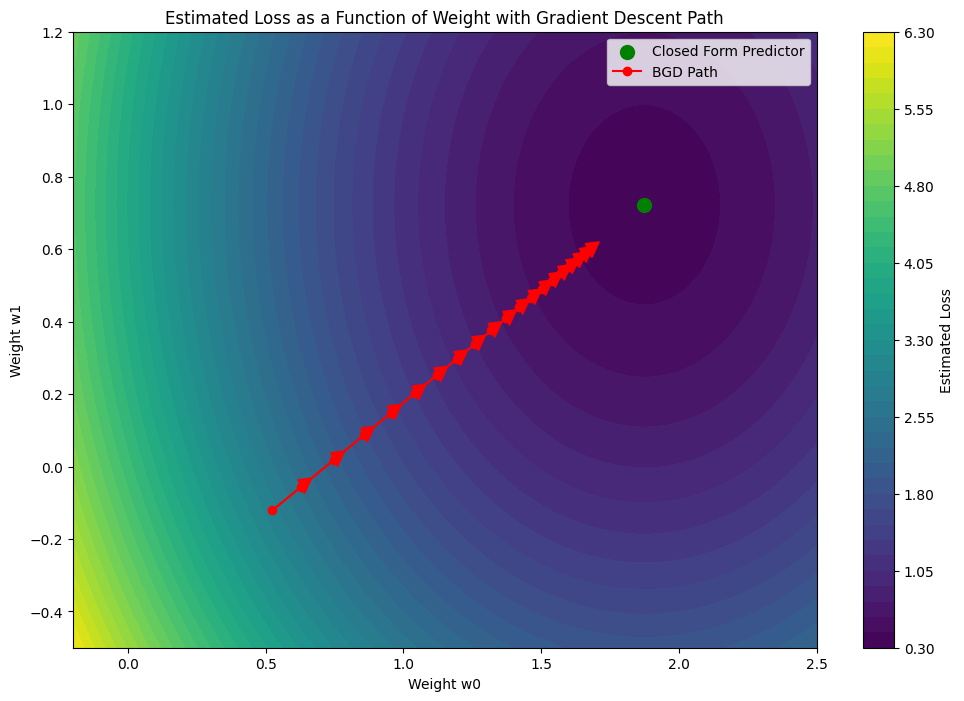

In [ ]:
# @title Plot
# Create a checkbox widget
show_plot_checkbox_loss = widgets.Checkbox(
    value=False,
    description='Show Plot',
    disabled=False
)

# Function to plot the data
def plot_data_loss(change):
    clear_output(wait=True)  # Clear the output before plotting or closing the plot
    display(show_plot_checkbox_loss)  # Re-display the checkbox after clearing

    if show_plot_checkbox_loss.value:
        # Get the closed form solution weights and loss
        closed_form_predictor, closed_form_weights = closed_form_learner(X_MedInc, Y)
        closed_form_loss = calculate_loss(X_MedInc, Y, closed_form_weights)

        # Define the range of weight values to evaluate
        w0_values = np.linspace(-0.2, 2.5, 100)
        w1_values = np.linspace(-0.5, 1.2, 100)

        # Create a meshgrid for the weight values
        W0, W1 = np.meshgrid(w0_values, w1_values)

        # Calculate the estimated loss for each pair of weight values
        loss_values = np.zeros_like(W0)
        for i in range(W0.shape[0]):
            for j in range(W0.shape[1]):
                w = np.array([W0[i, j], W1[i, j]])
                loss = calculate_loss(X_MedInc, Y, w)
                loss_values[i, j] = loss

        # Get the weight values from the BGD predictor for different epochs
        bgd_weights = []
        _, bgd_weight = batch_gradient_descent_learner(X_MedInc, Y, step_size=0.01, epochs=1)
        bgd_weights.append(bgd_weight)
        for epoch in range(5, 100, 5):
            _, bgd_weight = batch_gradient_descent_learner(X_MedInc, Y, step_size=0.01, epochs=epoch)
            bgd_weights.append(bgd_weight)

        bgd_weights = np.array(bgd_weights)

        # Get the weight values from the closed form predictor
        _, closed_form_weight = closed_form_learner(X_MedInc, Y)

        # Plot the estimated loss as a function of the weight vector in 2D
        plt.figure(figsize=(12, 8))
        plt.contourf(W0, W1, loss_values, levels=50, cmap='viridis')
        plt.colorbar(label='Estimated Loss')
        plt.scatter(closed_form_weight[0], closed_form_weight[1], color='green', s=100, label='Closed Form Predictor')
        plt.plot(bgd_weights[:, 0], bgd_weights[:, 1], marker='o', color='red', label='BGD Path')
        for i in range(len(bgd_weights) - 1):
            plt.arrow(bgd_weights[i, 0], bgd_weights[i, 1],
                      bgd_weights[i+1, 0] - bgd_weights[i, 0],
                      bgd_weights[i+1, 1] - bgd_weights[i, 1],
                      head_width=0.045, head_length=0.045, fc='red', ec='red')  # Arrows in red
        plt.xlabel('Weight w0')
        plt.ylabel('Weight w1')
        plt.title('Estimated Loss as a Function of Weight with Gradient Descent Path')
        plt.legend()
        plt.show()

# Attach the function to the checkbox
show_plot_checkbox_loss.observe(plot_data_loss, names='value')

# Display the checkbox
display(show_plot_checkbox_loss)


One last way we can visualize the estimated loss is by plotting the estimated loss as a function of the number of epochs.
This is sometimes called a learning curve, or a loss curve, and is perhaps the most commonly used way to visualize the performance of a learner in machine learning.

For this kind of plot we are not limited to visualizing a predictor that only uses a single feature.
In particular, now we can use all of the features in the dataset `X` instead of just the median income feature data `X_MedInc` to learn a predictor.
We plot the estimated loss as a function of the number of epochs for the predictor output by the batch gradient descent learner using only the median income feature data `X_MedInc`, and all the features in the dataset `X`.

What you should see is that the estimated loss decreases as the number of epochs increases for both cases.
You should also find that the estimated loss for the predictor output by the learner using all the features in the dataset `X` reached a lower value compared to the predictor output by the learner using only the matrix containing the median income feature `X_MedInc`.
This makes sense, since the learner has access to more information (features) and thus should be able to learn a predictor that better fits the data.

In [ ]:
# @title Plot

# Create a checkbox widget
show_plot_checkbox_loss_curve = widgets.Checkbox(
    value=False,
    description='Show Plot',
    disabled=False
)

# Function to plot the data
def plot_data_loss_curve(change):
    clear_output(wait=True)  # Clear the output before plotting or closing the plot
    display(show_plot_checkbox_loss_curve)  # Re-display the checkbox after clearing

    if show_plot_checkbox_loss_curve.value:
        # Define the number of epochs to evaluate
        epochs = range(1, 501)

        # Initialize empty lists to store the loss values for each dataset
        loss_values_X_MedInc = []
        loss_values_X = []

        # Train the model for each number of epochs and calculate the loss for each dataset
        for epoch in epochs:
            # For X_MedInc
            _, w_X_MedInc = batch_gradient_descent_learner(X_MedInc, Y, step_size=0.01, epochs=epoch)
            loss_X_MedInc = calculate_loss(X_MedInc, Y, w_X_MedInc)
            loss_values_X_MedInc.append(loss_X_MedInc)

            # For all features X
            _, w_X = batch_gradient_descent_learner(X, Y, step_size=0.01, epochs=epoch)
            loss_X = calculate_loss(X, Y, w_X)
            loss_values_X.append(loss_X)

        # Plot the loss as a function of the number of epochs for each dataset
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, loss_values_X_MedInc, label='X_MedInc')
        plt.plot(epochs, loss_values_X, label='All Features X')
        plt.xlabel('Number of Epochs')
        plt.ylabel('Loss')
        plt.title('Loss as a Function of Number of Epochs for Different Feature Sets')
        plt.yscale('log')
        plt.legend()
        plt.show()

# Attach the function to the checkbox
show_plot_checkbox_loss_curve.observe(plot_data_loss_curve, names='value')

# Display the checkbox
display(show_plot_checkbox_loss_curve)


Checkbox(value=False, description='Show Plot')

# Part 4: Polynomial Regression

Now we would like to explore how polynomial regression can be used to fit our data.
To do this you will need to implement a polynomial feature map.
We will keep things simply and only ask you to implement a degree 2 polynomial feature map.

In Question 4.1 your goal is to implement `phi_2` (representing $\phi_2$ from the course notes) which takes in a feature vector `x` and returns a new feature vector `poly_features` where `poly_features` is the degree 2 polynomial feature map of `x`.
The input `x` is of dimension $d+1$, since the first element is always 1 (to account for the bias term in the weights).
You should use the implementation of $\phi_2$ from the course notes as a reference.

### Question 4.1

Implement `phi_2`.

_Points:_ 8

In [ ]:
def phi_2(x):
    """
    Transforms a single feature vector into a polynomial of degree 2 feature vector.

    Parameters:
    x (numpy array): A single feature vector of size d+1.

    Returns:
    poly_features (numpy array): A transformed feature vector of size (d+1)*(d+2)/2.
    """
    # Calculate the size of the transformed feature vector
    d = len(x) - 1
    size = (d+1) * (d+2) // 2

    # Initialize the transformed feature vector with zeros
    poly_features = np.zeros(size)

    ### YOUR CODE HERE ###
    k = 0  # Initialize index for poly_features
    for i in range(d + 1):
        for j in range(i, d + 1):
            poly_features[k] = x[i] * x[j]
            k += 1


    ######################

    return poly_features


In [ ]:
grader.check("q4_1")

q4_1 results: All test cases passed!

### Visualizing and Comparing the Polynomial Predictor

We would like to use the polynomial feature map to transform the features of all the data points, however `phi_2` is only defined for a single feature vector `x`.
To apply the polynomial feature map to a matrix of features `X` we have implemented the function `transform_and_normalize`.
This function also normalizes the features after applying the polynomial feature map, which is important step as we discussed in [Understanding the Dataset](#part-1-understanding-the-dataset).


In [ ]:
def transform_and_normalize(X):
    """
    Transforms the feature matrix X using the given polynomial feature map function phi
    and normalizes the polynomial features.

    Parameters:
    X (numpy array): The feature matrix of size (n, d+1).
    phi (function): The polynomial feature map function to apply to each row of X.

    Returns:
    X_poly (numpy array): The transformed and normalized feature matrix.
    """
    # Apply the phi function to each row of X
    X_poly = np.array([phi_2(x) for x in X])

    # Normalize the polynomial features, excluding the first column
    X_poly_mean = X_poly[:, 1:].mean(axis=0)
    X_poly_std = X_poly[:, 1:].std(axis=0)
    X_poly[:, 1:] = (X_poly[:, 1:] - X_poly_mean) / X_poly_std

    return X_poly

So that we can visualize the polynomial predictor, we will again only use a single feature.
However, now we will use the feature describing the median number of rooms instead of the median income as we did in the previous sections.
This is because, as we will see in the plot, a quadratic function might be a better fit for this data.

Below we define the matrix `X_AveRooms` that only contains two columns, the first columns contains all 1s and the second column contains the average number of rooms feature.
We also define the matrix `X_AveRooms_poly` which is the polynomial feature map of `X_AveRooms`.

In [ ]:
X_AveRooms = np.hstack([np.ones((X.shape[0], 1)), X[:, 3].reshape(-1, 1)])
X_AveRooms_poly = transform_and_normalize(X_AveRooms)

Now we can pass `X_AveRooms_poly` and `Y` to the `closed_form_learner` to get the polynomial predictor and plot it against the true house prices.
We also include the linear predictor (produced by passing `X_AveRooms` to `Y` to the `closed_form_learner`) for comparison.

You should see two functions plotted, one that is a line (linear predictor) and one that is a quadratic (polynomial predictor).
The quadratic function should fit the data slightly better than the line.

Checkbox(value=True, description='Show Plot')

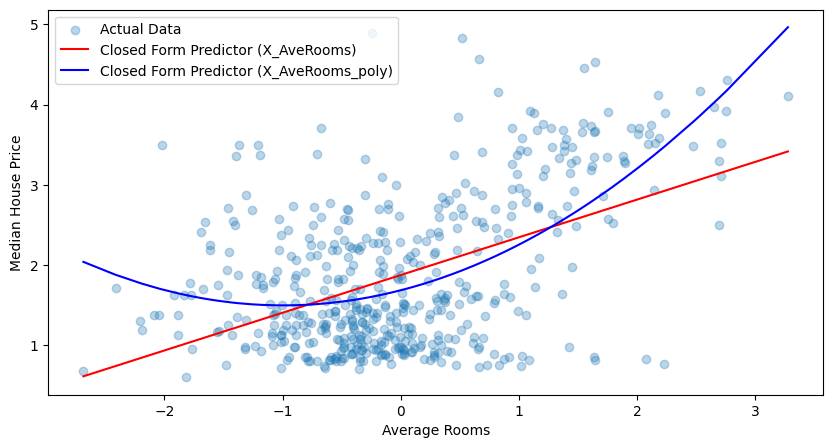

In [ ]:
# @title Plot

# Create a checkbox to control the display of the plot
show_plot_checkbox_scatter_poly = widgets.Checkbox(value=False, description='Show Plot')

# Function to update the plot based on the checkbox value
def plot_scatter_poly(change):
    clear_output(wait=True)
    display(show_plot_checkbox_scatter_poly)

    if show_plot_checkbox_scatter_poly.value:
        X_AveRooms_plot = X_AveRooms[:, 1]

        # Sort the x-axis and the Y predictions using the same indices
        sorted_indices = np.argsort(X_AveRooms_plot)
        X_AveRooms_plot_sorted = X_AveRooms_plot[sorted_indices]

        # Scatter plot of X_AveRooms vs Y
        plt.figure(figsize=(10, 5))
        plt.scatter(X_AveRooms_plot, Y, alpha=0.3, label='Actual Data')

        # Closed form predictor for X_AveRooms
        closed_form_predictor_AveRooms, closed_form_weights_AveRooms = closed_form_learner(X_AveRooms, Y)
        Y_pred_AveRooms = closed_form_predictor_AveRooms(X_AveRooms)
        Y_pred_AveRooms_sorted = Y_pred_AveRooms[sorted_indices]
        plt.plot(X_AveRooms_plot_sorted, Y_pred_AveRooms_sorted, color='red', label='Closed Form Predictor (X_AveRooms)')

        # Closed form predictor for X_AveRooms_poly
        closed_form_predictor_AveRooms_poly, closed_form_weights_AveRooms_poly = closed_form_learner(X_AveRooms_poly, Y)
        Y_pred_AveRooms_poly = closed_form_predictor_AveRooms_poly(X_AveRooms_poly)
        Y_pred_AveRooms_poly_sorted = Y_pred_AveRooms_poly[sorted_indices]
        plt.plot(X_AveRooms_plot_sorted, Y_pred_AveRooms_poly_sorted, color='blue', label='Closed Form Predictor (X_AveRooms_poly)')

        # Labels and legend
        plt.xlabel('Average Rooms')
        plt.ylabel('Median House Price')
        plt.legend()
        plt.show()

# Attach the function to the checkbox
show_plot_checkbox_scatter_poly.observe(plot_scatter_poly, names='value')

# Initial display
display(show_plot_checkbox_scatter_poly)

If you were not convinced by the previous plots that a quadratic function might be a better fit for the data, we can compute the estimated loss $\hat L(\hat{\mathbf{w}})$ of the linear and polynomial predictors.
This gives us a single number that quantifies how well the predictor fits the data.
Intuitively, this number tells us on average how far off the predictor is from the true house prices (in terms of a the squared distance).

Below you should see a bar plot containing two bars, one for the linear predictor and one for the polynomial predictor.
You should also see that the estimated loss for the polynomial predictor is lower than the estimated loss for the linear predictor.
This makes sense, since the polynomial features contain all the linear features, but also include all the quadratic features, which means the polynomial predictor always has at least as much information as the linear predictor.

Checkbox(value=True, description='Show Plot')

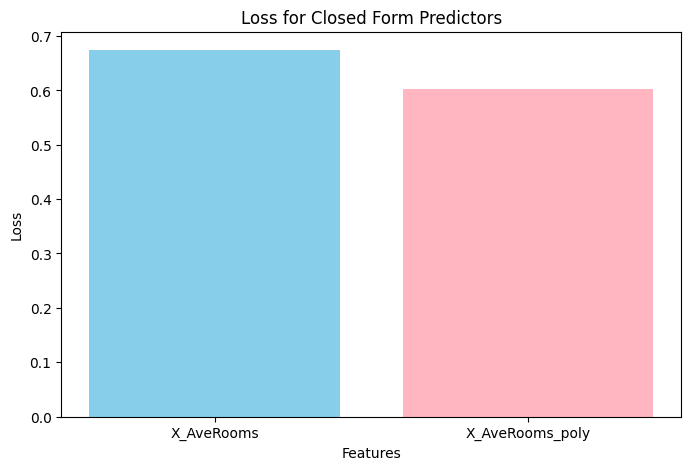

In [ ]:
# @title Plot

# Create a checkbox to control the display of the plot
show_plot_checkbox_loss_comparison_poly = widgets.Checkbox(value=False, description='Show Plot')


# Function to update the plot based on the checkbox value
def plot_loss_comparison_poly(change):
    clear_output(wait=True)
    display(show_plot_checkbox_loss_comparison_poly)

    # Define closed_form_weights_AveRooms and closed_form_weights_AveRooms_poly
    closed_form_predictor_AveRooms, closed_form_weights_AveRooms = closed_form_learner(X_AveRooms, Y)
    closed_form_predictor_AveRooms_poly, closed_form_weights_AveRooms_poly = closed_form_learner(X_AveRooms_poly, Y)

    if show_plot_checkbox_loss_comparison_poly.value:
        # Calculate the loss for the closed form predictor using X_AveRooms
        loss_AveRooms = calculate_loss(X_AveRooms, Y, closed_form_weights_AveRooms)

        # Calculate the loss for the closed form predictor using X_AveRooms_poly
        loss_AveRooms_poly = calculate_loss(X_AveRooms_poly, Y, closed_form_weights_AveRooms_poly)

        # Create a bar plot of the loss for the two predictors with softer colors
        plt.figure(figsize=(8, 5))
        plt.bar(['X_AveRooms', 'X_AveRooms_poly'], [loss_AveRooms, loss_AveRooms_poly], color=['#87CEEB', '#FFB6C1'])
        plt.xlabel('Features')
        plt.ylabel('Loss')
        plt.title('Loss for Closed Form Predictors')
        plt.show()

# Attach the function to the checkbox
show_plot_checkbox_loss_comparison_poly.observe(plot_loss_comparison_poly, names='value')

# Initial display
display(show_plot_checkbox_loss_comparison_poly)

We can also use the bar plot to compare the estimated loss of the linear and polynomial predictors obtained when `closed_form_learner` uses the matrix of all the features in the dataset `X` instead of the matrix containing just the average number of rooms feature `X_AveRooms`.

In the next code cell we transform the features in `X` into polynomial features `X_poly`.

In [ ]:
X_poly = transform_and_normalize(X)

In the plotting section of [Batch Gradient Descent](#part-3-batch-gradient-descent), we discussed how if the learner has access to more features, it should be able to learn a predictor that better fits the data.
We verify this by using a bar plot, but now include the estimated loss for the linear and polynomial predictors obtained when `closed_form_learner` is trained on all the features in the dataset `X` or `X_poly` instead of just the average number of rooms feature `X_AveRooms`.

You shold see that when all the features `X` or `X_poly` are used, the estimated loss for the predictors is lower than when only the average number of rooms feature `X_AveRooms` or `X_AveRooms_poly` is used.
You should also see that the predictor trained of `X_poly` has a lower estimated loss than the predictor trained on `X`.

Checkbox(value=True, description='Show Plot')

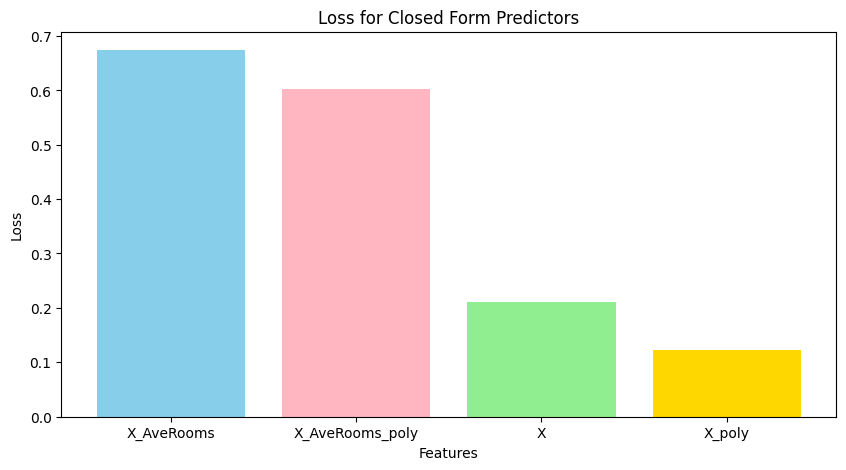

In [ ]:
# @title Plot

# Create a checkbox to control the display of the plot
show_plot_checkbox_loss_comparison_poly_full = widgets.Checkbox(value=False, description='Show Plot')

# Function to update the plot based on the checkbox value
def plot_loss_comparison_poly_full(change):
    clear_output(wait=True)
    display(show_plot_checkbox_loss_comparison_poly_full)

    # Define closed_form_weights_AveRooms and closed_form_weights_AveRooms_poly
    closed_form_predictor_AveRooms, closed_form_weights_AveRooms = closed_form_learner(X_AveRooms, Y)
    closed_form_predictor_AveRooms_poly, closed_form_weights_AveRooms_poly = closed_form_learner(X_AveRooms_poly, Y)
    closed_form_predictor_X, closed_form_weights_X = closed_form_learner(X, Y)
    closed_form_predictor_X_poly, closed_form_weights_X_poly = closed_form_learner(X_poly, Y)

    if show_plot_checkbox_loss_comparison_poly_full.value:
        # Calculate the loss for the closed form predictor using X_AveRooms
        loss_AveRooms = calculate_loss(X_AveRooms, Y, closed_form_weights_AveRooms)

        # Calculate the loss for the closed form predictor using X_AveRooms_poly
        loss_AveRooms_poly = calculate_loss(X_AveRooms_poly, Y, closed_form_weights_AveRooms_poly)

        # Calculate the loss for the closed form predictor using X
        loss_X = calculate_loss(X, Y, closed_form_weights_X)

        # Calculate the loss for the closed form predictor using X_poly
        loss_X_poly = calculate_loss(X_poly, Y, closed_form_weights_X_poly)

        # Create a bar plot of the loss for the four predictors with softer colors
        plt.figure(figsize=(10, 5))
        plt.bar(['X_AveRooms', 'X_AveRooms_poly', 'X', 'X_poly'],
                [loss_AveRooms, loss_AveRooms_poly, loss_X, loss_X_poly],
                color=['#87CEEB', '#FFB6C1', '#90EE90', '#FFD700'])
        plt.xlabel('Features')
        plt.ylabel('Loss')
        plt.title('Loss for Closed Form Predictors')
        plt.show()

# Attach the function to the checkbox
show_plot_checkbox_loss_comparison_poly_full.observe(plot_loss_comparison_poly_full, names='value')

# Initial display
display(show_plot_checkbox_loss_comparison_poly_full)

# Part 5: Mini-Batch Gradient Descent

Lets now implement the mini-batch gradient descent learner for linear regression.
In Question 5.1 your goal is to implement `minibatch_gradient_descent_learner` which takes all the same inputs as `batch_gradient_descent_learner` but also takes an additional parameter `batch_size` which is the size of the mini-batches.
You should use a constant step size `step_size` for this implementation.
Your implementation should be based on the MBGD Linear Regression learner from the course notes.

**A note on implementation:**
You should use `np.random.permutation` to help you shuffle the dataset `X` and `Y`.
This function returns a random permutation of the integers from 0 to `n` - 1, where `n` is the number of data points in the dataset.
For example, `np.random.permutation(5)` might return `[2, 0, 4, 1, 3]`.
You can use this permutation to shuffle the dataset by indexing the dataset with the permutation (e.g. `X[permutation]` will return a shuffled version of `X`).

### Question 5.1

Implement `minibatch_gradient_descent_learner`.

_Points:_ 8

In [ ]:
def minibatch_gradient_descent_learner(X, Y, step_size=0.01, epochs=10, batch_size=32, random_seed=42):
    '''
    Solves linear regression using mini-batch gradient descent with a fixed step size.

    Parameters:
    X (numpy array): Feature matrix of size (n, d+1), where n is the number of samples
                     and d is the number of features. The first column should be all 1s.
    Y (numpy array): Target vector of size (n, 1).
    step_size (float): The step size for gradient descent.
    epochs (int): The number of iterations to run gradient descent.
    batch_size (int): The size of each mini-batch.
    random_seed (int): The seed for the random number generator.

    Returns:
    predictor (function): A function that takes a feature vector and returns a predicted value.
    w (numpy array): The final weights after applying gradient descent for the specified epochs.
    '''
    np.random.seed(random_seed)  # Set the random seed for reproducibility
    n, d = X[:, 1:].shape
    w = np.random.randn(d+1) # initialize the weights randomly
    M = np.floor(n / batch_size).astype(int)  # Number of mini-batches

    ### YOUR CODE HERE ###
    for t in range(epochs):
        # Shuffle the dataset at the beginning of each epoch
        permutation = np.random.permutation(n)
        X_shuffled = X[permutation]
        Y_shuffled = Y[permutation]

        # Loop over mini-batches
        for m in range(M):
            # Select the mini-batch
            start_idx = m * batch_size
            end_idx = start_idx + batch_size
            X_batch = X_shuffled[start_idx:end_idx]
            Y_batch = Y_shuffled[start_idx:end_idx]

            # Compute predictions for the current mini-batch
            predictions = X_batch @ w  # Predicted values: Xw
            errors = predictions - Y_batch.flatten()  # Compute error: (Xw - Y)

            # Compute gradient for the mini-batch
            gradient = (2 / batch_size) * (X_batch.T @ errors)

            # Update weights
            w -= step_size * gradient



    ######################

    def predictor(x):
        return x @ w

    return predictor, w


In [ ]:
grader.check("q5_1")

q5_1 results: All test cases passed!

## Comparing Different Batch Sizes

Lets continue with the example from the [Polynomial Regression](#part-4-polynomial-regression) section where we used the matrix `X_poly` containing all the features in the dataset `X` transformed into polynomial features.
Recall that the `closed_form_learner` outputs the predictor that exactly minimizes the estimated loss $\hat L(\mathbf{w})$.
Thus, a good way to evaluate the performance of the `minibatch_gradient_descent_learner` is to compare the estimated loss of the predictor it outputs to the estimated loss of the predictor output by the `closed_form_learner`.
We will do this for different batch sizes: $1, 32$ and $n$ (which is the full batch and is equivalent to the batch gradient descent learner).
We also run the `minibatch_gradient_descent_learner` for 1000 epochs, which should be more than enough epochs for the predictor to converge to a good solution.

We show a bar plot of the results. You should see that the estimated loss for the closed form predictor has the smallest value, and that the estimated loss for the mini-batch gradient descent predictor approaches the estimated loss for the closed form predictor as the batch size decreases.
This gives us some practical verification that indeed using a smaller batch size can be a good idea.
In particular for this dataset, using a batch size of 1 seems to be the best.

Checkbox(value=True, description='Show Plot')

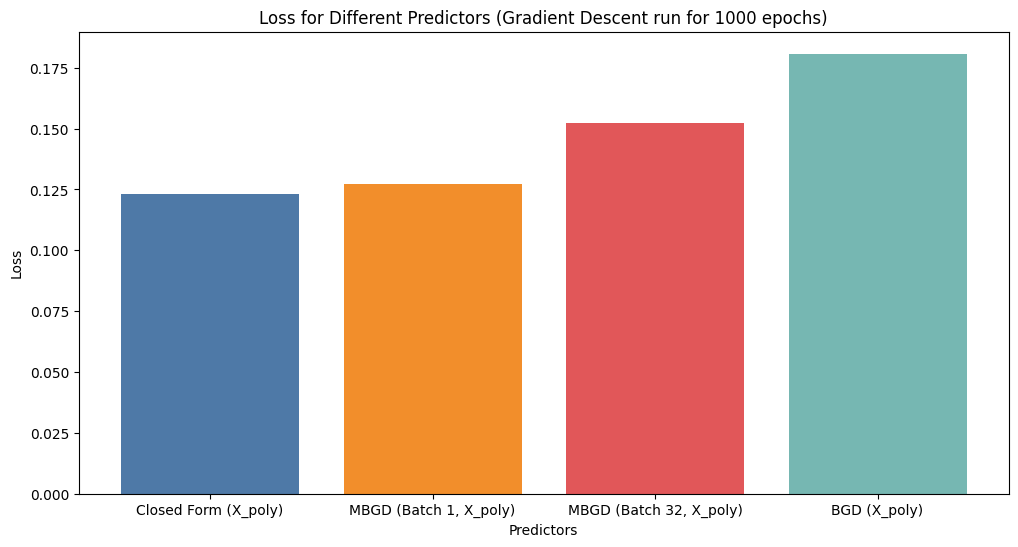

In [ ]:
# @title Plot

# Create a checkbox to control the display of the plot
show_plot_checkbox_minibatch = widgets.Checkbox(value=False, description='Show Plot')

# Function to update the plot based on the checkbox value
def plot_minibatch(change):
    clear_output(wait=True)
    display(show_plot_checkbox_minibatch)

    # Define the number of epochs
    epochs = 1000

    # Closed form predictors
    closed_form_predictor_X_poly, closed_form_weights_X_poly = closed_form_learner(X_poly, Y)

    # Calculate the loss for the closed form predictors
    loss_X_poly = calculate_loss(X_poly, Y, closed_form_weights_X_poly)

    # Minibatch gradient descent with batch size 32
    _, w_mb_32_poly = minibatch_gradient_descent_learner(X_poly, Y, step_size=0.001, epochs=epochs, batch_size=32)
    loss_mb_32_poly = calculate_loss(X_poly, Y, w_mb_32_poly)

    # Minibatch gradient descent with batch size 1
    _, w_mb_1_poly = minibatch_gradient_descent_learner(X_poly, Y, step_size=0.0001, epochs=epochs, batch_size=1)
    loss_mb_1_poly = calculate_loss(X_poly, Y, w_mb_1_poly)

    # Batch gradient descent (batch size = n)
    _, w_bgd_poly = batch_gradient_descent_learner(X_poly, Y, step_size=0.01, epochs=epochs)
    loss_bgd_poly = calculate_loss(X_poly, Y, w_bgd_poly)

    # Create a bar plot of the losses
    labels = ['Closed Form (X_poly)', 'MBGD (Batch 1, X_poly)', 'MBGD (Batch 32, X_poly)', 'BGD (X_poly)']
    losses = [loss_X_poly, loss_mb_1_poly, loss_mb_32_poly, loss_bgd_poly]

    # Define a more visually appealing color palette
    colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2']

    if show_plot_checkbox_minibatch.value:
        plt.figure(figsize=(12, 6))
        plt.bar(labels, losses, color=colors)
        plt.xlabel('Predictors')
        plt.ylabel('Loss')
        plt.title('Loss for Different Predictors (Gradient Descent run for 1000 epochs)')
        plt.xticks(rotation=0)
        plt.show()

# Attach the function to the checkbox
show_plot_checkbox_minibatch.observe(plot_minibatch, names='value')

# Initial display
display(show_plot_checkbox_minibatch)


# Part 6: Step Sizes

So far we have been using a constant step size $\eta^{(t)} = \eta$.
However, in class we learned that the step size can be chosen in a variety of ways.
In this section we will explore how different step sizes can affect the performance of the batch gradient descent learner.

To do this, you will need to implement the different step size functions described in class.
To keep the inputs consistent for all the step size functions, we will assume the input is a dictionary `state` that contains the following keys:
- `eta` which is the initial step size,
- `lambda_` which is the decay rate,
- `epoch` which is the current epoch,
- `gradient` which is the gradient at the current epoch,
- `eps` which is a small constant to prevent division by zero.

You can access the values of the dictionary using the keys, for example `state['eta']` will return the initial step size.
As an example, we implement the constant step size function `constant_step_size` below, which is defined as $\eta^{(t)} = \eta$.

In [ ]:
def constant_step_size(state):
    """
    Returns a constant step size.

    Parameters:
    state (dict): A dictionary containing the state variables, including 'eta'.

    Returns:
    float: The constant step size.
    """
    step_size = state['eta']
    return step_size

### Question 6.1

Implement `inverse_decaying_step_size` which is defined as
$$\eta^{(t)} = \frac{\eta}{1 + \lambda t}$$

_Points:_ 4

In [ ]:
def inverse_decaying_step_size(state):
    """
    Returns an inverse decaying step size.

    Parameters:
    state (dict): A dictionary containing the state variables, including 'eta', 'lambda_', and 'epoch'.

    Returns:
    step_size (float): The step size for the given epoch.
    """
    ### YOUR CODE HERE ###

    eta = state['eta']         # Initial step size
    lambda_ = state['lambda_'] # Decay rate
    epoch = state['epoch']     # Current epoch

    # Compute the inverse decaying step size
    step_size = eta / (1 + lambda_ * epoch)

    ######################
    return step_size

In [ ]:
grader.check("q6_1")

q6_1 results: All test cases passed!

### Question 6.2

Implement `exponential_decaying_step_size` which is defined as
$$\eta^{(t)} = \eta \exp(-\lambda t).$$
You can use `np.exp` to implement the exponential function.

_Points:_ 4

In [ ]:
def exponential_decaying_step_size(state):
    """
    Returns an exponentially decaying step size.

    Parameters:
    state (dict): A dictionary containing the state variables, including 'eta', 'lambda_', and 'epoch'.

    Returns:
    step_size (float): The step size for the given epoch.
    """
    ### YOUR CODE HERE ###

    eta = state['eta']         # Initial step size
    lambda_ = state['lambda_'] # Decay rate
    epoch = state['epoch']     # Current epoch

    # Compute the exponentially decaying step size
    step_size = eta * np.exp(-lambda_ * epoch)

    ######################
    return step_size

In [ ]:
grader.check("q6_2")

q6_2 results: All test cases passed!

### Question 6.3

Implement `normalized_gradient_step_size` which is defined as
$$\eta^{(t)} = \frac{\eta}{\epsilon + \| \text{gradient} \|}.$$
You can use `np.linalg.norm` to calculate the 2-norm of the gradient

_Points:_ 4

In [ ]:
def normalized_gradient_step_size(state):
    """
    Returns a normalized step size based on the gradient.

    Parameters:
    state (dict): A dictionary containing the state variables, including 'eta', 'gradient', and 'eps'.

    Returns:
    step_size (float): The normalized step size.
    """

    ### YOUR CODE HERE ###

    # Extract values from the state dictionary
    eta = state['eta']         # Initial step size
    gradient = state['gradient']  # Gradient at current epoch
    eps = state['eps']         # Small epsilon to prevent division by zero

    # Compute the 2-norm (Euclidean norm) of the gradient
    gradient_norm = np.linalg.norm(gradient)

    # Compute the normalized step size
    step_size = eta / (eps + gradient_norm)

    ######################
    return step_size

In [ ]:
grader.check("q6_3")

q6_3 results: All test cases passed!

### Question 6.4

Now that you have implemented the different step size functions, you have to modify the `batch_gradient_descent_learner` to accept a `step_size_func` parameter.
We will call this new learner `batch_gradient_descent_learner_ss` (ss stands for step size).
Compared to the previous `batch_gradient_descent_learner`, the new learner takes as input the additional parameters:
- `step_size_func` which is the step size function to use,
- `eta` which is the initial step size (previously we called this `step_size`),
- `lambda_` which is the decay rate
- `eps` which is a small constant to prevent division by zero.

We have already started the implementation for you by defining the `state` dictionary.
Your implementation of `batch_gradient_descent_learner_ss` should look similar to your implementation of `batch_gradient_descent_learner`, but with the step size being calculated using the `step_size_func` function.
Also, make sure to update the `epoch` and `gradient` values in the `state` dictionary before calling the `step_size_func`.

_Points:_ 4

In [ ]:
def batch_gradient_descent_learner_ss(X, Y, step_size_func, eta=0.01, lambda_=0.01, epochs=10, eps=1e-8, random_seed=42):
    '''
    Solves linear regression using batch gradient descent with a custom step size function.

    Parameters:
    X (numpy array): Feature matrix of size (n, d+1), where n is the number of samples
                     and d is the number of features. The first column should be all 1s.
    Y (numpy array): Target vector of size (n, 1).
    step_size_func (function): A function that takes a state dictionary and returns the step size.
    eta (float): The initial step size for gradient descent.
    lambda_ (float): The decay rate for the step size functions that require it.
    epochs (int): The number of iterations to run gradient descent.
    eps (float): A small value to prevent division by zero in the normalized gradient step size function.
    random_seed (int, optional): A random seed for initializing the weights.

    Returns:
    predictor (function): A function that takes a feature vector and returns a predicted value.
    w (numpy array): The final weights after applying gradient descent for the specified epochs.
    '''
    n, d = X[:, 1:].shape
    np.random.seed(random_seed)
    w = np.random.randn(d+1) # initialize the weights randomly

    # Initialize the state dictionary
    state = {
        'eta': eta,
        'lambda_': lambda_,
        'epoch': 1,
        'gradient': np.zeros(d+1),
        'eps': eps
    }

    ### YOUR CODE HERE ###
    for epoch in range(epochs):
        # Step 1: Compute predictions for the entire dataset
        predictions = X @ w  # Predicted values (shape: (n,))

        # Step 2: Compute the gradient for the entire dataset
        errors = predictions - Y.flatten()  # Compute the error
        gradient = (2 / n) * (X.T @ errors)  # Compute the gradient

        # Update the state with the current gradient and epoch
        state['gradient'] = gradient
        state['epoch'] = epoch

        # Step 3: Get the step size using the provided step_size_func
        step_size = step_size_func(state)  # Call the step size function

        # Step 4: Update weights using the computed step size and gradient
        w -= step_size * gradient


    ######################

    def predictor(x):
        return x @ w

    return predictor, w

In [ ]:
grader.check("q6_4")

q6_4 results: All test cases passed!

### Learning Curves for Different Step Sizes

We can once again continue with using `X_poly` and `Y` as the dataset.
We will compare the performance of the different step size functions by plotting the estimated loss $\hat L(\mathbf{w})$ as a function of the number of epochs for each step size function.

You can use the sliders to change the different parameters of the step size functions.

You should see that when you make `eta` too large the estimated loss can actually increase.
This is the case we saw in class where the step size is too large and the learner overshoots the minimum more and more after each step, causing for gradient descent to diverge.

In [ ]:
# @title Plot

# Define the number of epochs to evaluate
epochs_lr = range(0, 50)

# Create sliders for each step size function
eta_slider_constant = widgets.FloatSlider(value=0.2, min=0.00, max=0.4, step=0.01, description='Eta (Const):')
eta_slider_inverse = widgets.FloatSlider(value=0.10, min=0.000, max=0.4, step=0.001, description='Eta (Inv):')
lambda_slider_inverse = widgets.FloatSlider(value=0.01, min=0.000, max=1.0, step=0.001, description='Lambda (Inv):')
eta_slider_exponential = widgets.FloatSlider(value=0.25, min=0.000, max=0.4, step=0.001, description='Eta (Exp):')
lambda_slider_exponential = widgets.FloatSlider(value=0.01, min=0.000, max=1.0, step=0.001, description='Lambda (Exp):')
eta_slider_normalized = widgets.FloatSlider(value=0.30, min=0.000, max=1.0, step=0.001, description='Eta (Norm):')

# Create a checkbox to control the display of the plot
show_plot_checkbox_lr = widgets.Checkbox(value=False, description='Show Plot')

# Arrange sliders in 4 columns
column1 = widgets.VBox([eta_slider_constant])
column2 = widgets.VBox([eta_slider_inverse, lambda_slider_inverse])
column3 = widgets.VBox([eta_slider_exponential, lambda_slider_exponential])
column4 = widgets.VBox([eta_slider_normalized])
slider_layout = widgets.HBox([column1, column2, column3, column4])

# Function to update the plot based on the slider values
def update_plot_lr(eta_constant, eta_inverse, lambda_inverse, eta_exponential, lambda_exponential, eta_normalized, show_plot):
    # # Clear the output before plotting or closing the plot
    # clear_output(wait=True)

    # # Re-display the sliders and checkbox
    # display(slider_layout, show_plot_checkbox_lr)

    # Initialize empty lists to store the loss values for each step size function
    loss_values_constant = []
    loss_values_inverse = []
    loss_values_exponential = []
    loss_values_normalized = []

    # Train the model for each number of epochs and calculate the loss for each step size function
    for epoch in epochs_lr:
        # Constant step size
        _, w_constant = batch_gradient_descent_learner_ss(X_poly, Y, step_size_func=constant_step_size, eta=eta_constant, epochs=epoch)
        loss_constant = calculate_loss(X_poly, Y, w_constant)
        loss_values_constant.append(loss_constant)

        # Inverse decaying step size
        _, w_inverse = batch_gradient_descent_learner_ss(X_poly, Y, step_size_func=inverse_decaying_step_size, eta=eta_inverse, lambda_=lambda_inverse, epochs=epoch)
        loss_inverse = calculate_loss(X_poly, Y, w_inverse)
        loss_values_inverse.append(loss_inverse)

        # Exponential decaying step size
        _, w_exponential = batch_gradient_descent_learner_ss(X_poly, Y, step_size_func=exponential_decaying_step_size, eta=eta_exponential, lambda_=lambda_exponential, epochs=epoch)
        loss_exponential = calculate_loss(X_poly, Y, w_exponential)
        loss_values_exponential.append(loss_exponential)

        # Normalized gradient step size
        _, w_normalized = batch_gradient_descent_learner_ss(X_poly, Y, step_size_func=normalized_gradient_step_size, eta=eta_normalized, epochs=epoch)
        loss_normalized = calculate_loss(X_poly, Y, w_normalized)
        loss_values_normalized.append(loss_normalized)

    # Plot the loss as a function of the number of epochs for each step size function if the checkbox is checked
    if show_plot:
        plt.figure(figsize=(10, 5))
        plt.plot(epochs_lr, loss_values_constant, label='Constant Step Size')
        plt.plot(epochs_lr, loss_values_inverse, label='Inverse Decaying Step Size')
        plt.plot(epochs_lr, loss_values_exponential, label='Exponential Decaying Step Size')
        plt.plot(epochs_lr, loss_values_normalized, label='Normalized Gradient Step Size')
        plt.xlabel('Number of Epochs')
        plt.ylabel('Loss')
        plt.title('Loss as a Function of Number of Epochs for Different Step Size Functions')
        plt.yscale('log')
        plt.legend()
        plt.show()
    else:
        # Clear the output to hide the plot when "Show Plot" is unchecked
        clear_output()


# Use interactive_output to link the sliders and checkbox to the update_plot_lr function
interactive_plot_lr = interactive_output(update_plot_lr, {
    'eta_constant': eta_slider_constant,
    'eta_inverse': eta_slider_inverse,
    'lambda_inverse': lambda_slider_inverse,
    'eta_exponential': eta_slider_exponential,
    'lambda_exponential': lambda_slider_exponential,
    'eta_normalized': eta_slider_normalized,
    'show_plot': show_plot_checkbox_lr
})

# Initial display
display(slider_layout, show_plot_checkbox_lr, interactive_plot_lr)


Checkbox(value=False, description='Show Plot')

Output()

# The End, I hope you had fun :)

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()

q2_1 results: All test cases passed!

q3_1 results: All test cases passed!

q4_1 results: All test cases passed!

q5_1 results: All test cases passed!

q6_1 results: All test cases passed!

q6_2 results: All test cases passed!

q6_3 results: All test cases passed!

q6_4 results: All test cases passed!